In [1]:
import os
import glob as glob
import timecorr as tc
import hypertools as hyp
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.decomposition import PCA, IncrementalPCA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
import timecorr as tc
from timecorr.helpers import isfc, wisfc, mean_combine, corrmean_combine
import supereeg as se
import hypertools as hyp

In [2]:
def rbf(centers, widths, locs):
    """
    Radial basis function
    Parameters
    ----------
    centers : ndarray
        rbf coordinates (one row per RBF)
    widths : ndarray
        RBF radii
    locs : ndarray
        locations to evaluate the RBFs (one row per location)
        
    Returns
    ----------
    results : ndarray
        Matrix of RBF weights for each RBF (row), at each location (column)
    """    
    weights = np.exp(np.divide(-cdist(locs, centers, metric='euclidean') ** 2, np.tile(np.array(widths, ndmin=2), [locs.shape[0], 1])))
    return weights.T

In [3]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [71]:
def reduce_list(x, model):
    split = np.cumsum([len(xi) for xi in x])[:-1]
    x_r = np.vsplit(model.fit_transform(np.vstack(x)), split)
    if len(x) > 1:
        return [xi for xi in x_r]
    else:
        return [x_r[0]]

In [4]:
datadir = os.path.join(os.getenv('HOME'), 'Desktop', 'pca_env', 'pca_paper', 'pieman', 'data')


In [5]:
figdir = '../figs'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [6]:
neurosynth_dir ='../figs/neurosynth_data/'
if not os.path.exists(neurosynth_dir):
    os.mkdir(neurosynth_dir)

In [7]:
n_f_dir = os.path.join(neurosynth_dir, 'figs')
if not os.path.exists(n_f_dir):
    os.mkdir(n_f_dir)
nii_dir = os.path.join(neurosynth_dir, 'niis')
if not os.path.exists(nii_dir):
    os.mkdir(nii_dir)
txt_dir = os.path.join(neurosynth_dir, 'txts')
if not os.path.exists(txt_dir):
    os.mkdir(txt_dir)
p_txt_dir = os.path.join(txt_dir, 'parsed_txts')
if not os.path.exists(p_txt_dir):
    os.mkdir(p_txt_dir)

In [8]:
ddir = '../../data/'

In [9]:
#figdir = '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/figs'

In [10]:
#results_dir = os.path.join(os.getenv('HOME'), 'Desktop', 'timecorr_env', 'timecorr_paper', 'pieman', 'results')
results_dir = os.path.join('../../data/', 'results')

In [11]:
posterior = loadmat(os.path.join(ddir, 'pieman_posterior_K700.mat'))
centers = posterior['posterior']['centers'][0][0][0][0][0]
widths = np.array(list(posterior['posterior']['widths'][0][0][0][0][0][:, 0].T))

In [12]:
factors=700

In [13]:
if factors == 100:
    pieman_name = '../../data/pieman_ica100.mat'
else:
    pieman_name = '../../data/pieman_data.mat'

pieman_conds = ['intact', 'paragraph', 'word', 'rest']

In [14]:
pieman_data = loadmat(pieman_name)

In [15]:
debug = False

In [16]:
if debug:
    data = []
    conds = []
    for c in pieman_conds:
        next_data = list(map(lambda i: pieman_data[c][:, i][0][:30, :10], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

else:

    data = []
    conds = []
    for c in pieman_conds:
        if c == 'paragraph':
            if factors == 700:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
            else:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 0)[0]))
        else:
            next_data = list(map(lambda i: pieman_data[c][:, i][0], np.arange(pieman_data[c].shape[1])))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

In [17]:
data = np.array(data)
conds = np.array(conds)

In [102]:
pca = IncrementalPCA(n_components=1)

In [112]:
x = list(data[conds == 'intact'])
split = np.cumsum([len(xi) for xi in x])[:-1]

[array([[ 0.86002639,  0.0504506 ,  0.44193355, ...,  2.2364127 ,
          1.90083687, -0.54789545],
        [ 1.15798977,  0.3911441 , -2.09692154, ...,  1.90107118,
          4.09946925, -0.97704309],
        [ 2.51845202,  0.35104619, -2.09971427, ...,  1.31928778,
          2.29581878, -1.05497914],
        ...,
        [-0.05783029,  0.40186573, -0.64830814, ...,  0.95281121,
          0.66117743, -1.12818568],
        [ 0.63797543,  1.2172146 , -1.42308967, ...,  1.77351663,
         -0.45300959, -0.65450354],
        [-0.91507128,  0.03718218, -0.94379748, ...,  1.43874632,
         -1.30591732,  0.24972308]]),
 array([[-1.5541844 ,  0.06085483, -0.68790086, ..., -2.71061319,
          0.06173995,  0.10120613],
        [-0.13942399, -0.95083388, -0.34867731, ..., -2.85443937,
         -1.17052946,  0.44760893],
        [ 0.83575168,  0.34209803,  1.65007638, ..., -1.45526895,
         -0.46866893,  0.60238898],
        ...,
        [ 0.99243758,  0.61044568,  0.98025814, ...,  

In [137]:
pca = IncrementalPCA(n_components=10)
x_r = np.vsplit(pca.fit_transform(np.vstack(x)), split)

In [138]:
pca.components_.shape

(10, 700)

In [139]:
combined_pca = np.mean(np.stack(x_r, axis=2), axis=2)

In [140]:
approximation_combined = pca.inverse_transform(combined_pca)

In [142]:
approximation_combined[0][0]

0.0031045151452002728

In [133]:
pca = IncrementalPCA(n_components=100)
x_r = np.vsplit(pca.fit_transform(np.vstack(x)), split)

In [134]:
combined_pca = np.mean(np.stack(x_r, axis=2), axis=2)

In [135]:
approximation_combined = pca.inverse_transform(combined_pca)

In [144]:
approximation_combined

array([[ 0.00310452,  0.04185878,  0.25022699, ...,  0.70506435,
         0.45428636,  0.35704573],
       [-0.16473674, -0.01173099, -0.1012212 , ...,  0.19548427,
         0.11610324,  0.02195469],
       [-0.18872945, -0.05700816, -0.31391412, ..., -0.15742722,
        -0.1374241 , -0.14000493],
       ...,
       [-0.02507632, -0.12675247, -0.06366876, ..., -0.01014897,
         0.14727444,  0.06501421],
       [-0.00959996, -0.09804801, -0.09472033, ..., -0.03450505,
         0.09832523,  0.05608514],
       [ 0.02728414, -0.0627671 ,  0.02745492, ...,  0.02114319,
         0.16086209,  0.08561003]])

In [118]:
pca = IncrementalPCA(n_components=10)

In [42]:
pca_t = IncrementalPCA(n_components=1)


In [47]:
try_fit = pca.fit(data[conds == 'intact'][0])

In [51]:
try_fit.components_.shape

(1, 700)

In [21]:
combined_pca = np.mean(np.stack(pca_data, axis=2), axis=2)

In [23]:
combined_pca.shape

(300, 10)

In [31]:
data[conds == 'intact'][0].shape

(300, 700)

In [41]:
lower_d_data = pca.fit_transform(data[conds == 'intact'][0])

In [30]:
lower_d_data.shape

(300, 1)

In [29]:
pca.components_.

(1, 700)

In [27]:
lower_d_data.shape

(300, 1)

In [116]:
template = se.helpers._gray(res=2)

In [157]:
net_inds = largest_indices(np.atleast_2d(approximation_combined).mean(axis=1), 10)

In [169]:
largest_indices(np.atleast_2d(approximation_combined).mean(axis=1), 10)

(array([  0, 296, 154, 297, 153, 295, 155, 156, 292, 293]),)

In [183]:
zscore_approx = (approximation_combined -approximation_combined.min())/approximation_combined.max()

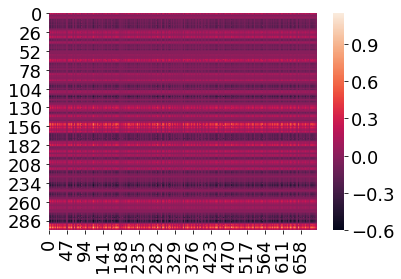

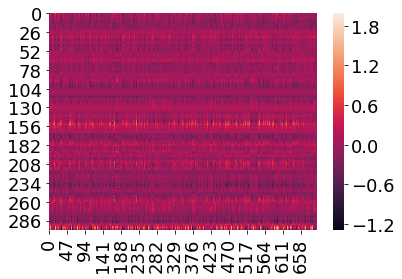

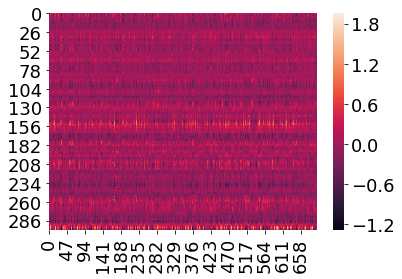

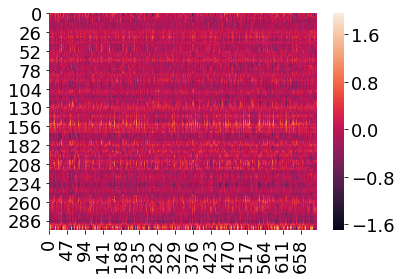

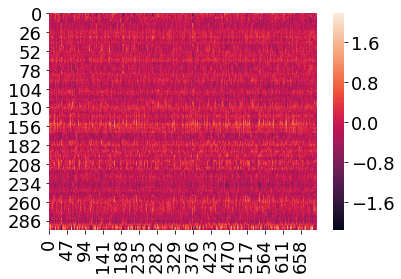

In [190]:
#conditions = ['intact', 'paragraph', 'rest', 'word']
conditions = ['intact']

for c in conditions:
    x = list(data[conds == c])
    split = np.cumsum([len(xi) for xi in x])[:-1]
    
    for i in [1,5,10,20,100]:
        
        pca = IncrementalPCA(n_components=i)
        x_r = np.vsplit(pca.fit_transform(np.vstack(x)), split)

        combined_pca = np.mean(np.stack(x_r, axis=2), axis=2)
        approximation_combined = pca.inverse_transform(combined_pca)
        sns.heatmap(approximation_combined)
        plt.show()
        #print(largest_indices(np.atleast_2d(approximation_combined).mean(axis=1), 50))
#         net_inds = largest_indices(np.atleast_2d(approximation_combined).mean(axis=1), 10)
#         temp_locs = centers[net_inds]
#         temp_widths = widths[net_inds]
#         w = rbf(temp_locs, temp_widths, template.get_locs().values)
#         b = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=template.get_locs(), minimum_voxel_size=2)
#         nii = se.Nifti(b)
#         print('PCA = ' + str(i))
#         nii.plot_glass_brain()

In [194]:
zscore_approx[0].shape

(700,)

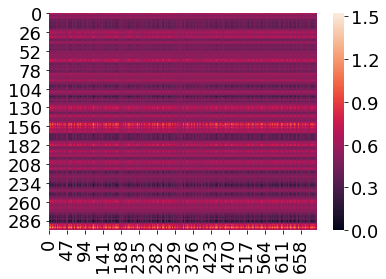

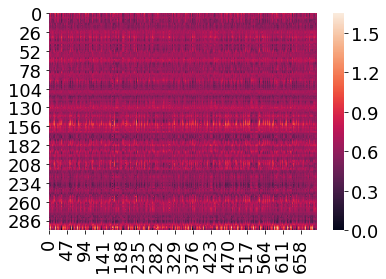

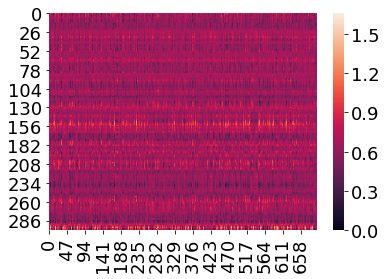

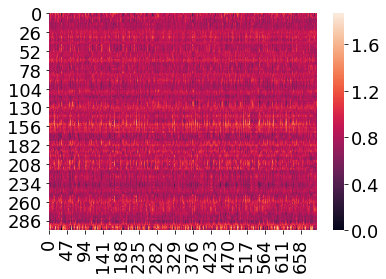

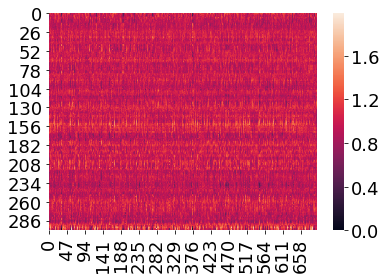

In [191]:
#conditions = ['intact', 'paragraph', 'rest', 'word']
conditions = ['intact']

for c in conditions:
    x = list(data[conds == c])
    split = np.cumsum([len(xi) for xi in x])[:-1]
    
    for i in [1,5,10,20,100]:
        
        pca = IncrementalPCA(n_components=i)
        x_r = np.vsplit(pca.fit_transform(np.vstack(x)), split)

        combined_pca = np.mean(np.stack(x_r, axis=2), axis=2)
        approximation_combined = pca.inverse_transform(combined_pca)
        zscore_approx = (approximation_combined -approximation_combined.min())/approximation_combined.max()
        sns.heatmap(zscore_approx)
        plt.show()

        temp_locs = centers
        temp_widths = widths[net_inds]
        w = rbf(temp_locs, temp_widths, template.get_locs().values)
        b = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=template.get_locs(), minimum_voxel_size=2)
        nii = se.Nifti(b)
        print('PCA = ' + str(i))
        nii.plot_glass_brain()

In [ ]:
#conditions = ['intact', 'paragraph', 'rest', 'word']
conditions = ['intact']

for c in conditions:
    x = list(data[conds == c])
    split = np.cumsum([len(xi) for xi in x])[:-1]
    
    for i in [1,5,10,20,100]:
        
        pca = IncrementalPCA(n_components=i)
        x_r = np.vsplit(pca.fit_transform(np.vstack(x)), split)

        combined_pca = np.mean(np.stack(x_r, axis=2), axis=2)
        approximation_combined = pca.inverse_transform(combined_pca)
        zscore_approx = (approximation_combined -approximation_combined.min())/approximation_combined.max()
        sns.heatmap(zscore_approx)
        plt.show()
        #print(largest_indices(np.atleast_2d(approximation_combined).mean(axis=1), 50))
#         net_inds = largest_indices(np.atleast_2d(approximation_combined).mean(axis=1), 10)
#         temp_locs = centers[net_inds]
#         temp_widths = widths[net_inds]
#         w = rbf(temp_locs, temp_widths, template.get_locs().values)
#         b = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=template.get_locs(), minimum_voxel_size=2)
#         nii = se.Nifti(b)
#         print('PCA = ' + str(i))
#         nii.plot_glass_brain()

In [155]:
conditions = ['intact', 'paragraph', 'rest', 'word']


for c in conditions:

    pca_data = np.asarray(hyp.reduce(list(data[conds == 'intact']), ndims=10))
    pca = IncrementalPCA(n_components=10)
    combined_pca = np.mean(np.stack(pca_data, axis=2), axis=2)
    approximation_combined = pca.inverse_transform(combined_pca)
    for i in np.arange(10):
        net_inds = largest_indices(np.atleast_2d(approximation_combined[i]).mean(axis=0), 10)
        temp_locs = centers[net_inds]
        temp_widths = widths[net_inds]
        w = rbf(temp_locs, temp_widths, template.get_locs().values)
        b = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=template.get_locs(), minimum_voxel_size=2)
        nii = se.Nifti(b)
        print('PCA = ' + str(i))
        nii.plot_glass_brain()

AttributeError: 'IncrementalPCA' object has no attribute 'components_'

In [92]:
pca_data.shape

(36, 300, 10)

In [154]:
data[conds == 'intact'].shape

(36,)

In [158]:
pca = IncrementalPCA(n_components=10)
#lower_d_data = pca.fit_transform(data[conds == 'intact'][0])
#print(pca.explained_variance_ratio_)

In [162]:
pca.components_=combined_pca


In [163]:
pca.inverse_transform(combined_pca)

ValueError: shapes (300,10) and (300,10) not aligned: 10 (dim 1) != 300 (dim 0)

In [145]:
pca_data.shape

(36, 300, 10)

In [139]:
combined_pca = np.mean(np.stack(pca_data, axis=2), axis=2)

In [140]:
combined_pca.shape

(300, 10)

In [142]:
combined_pca[:, 0]

array([ 1.66928816e+01,  4.57535825e+00,  1.58847972e+00,  3.85979409e-01,
       -7.14391562e-01,  2.98872299e-01,  1.99617761e+00,  1.23435327e+00,
       -2.41965525e-02, -2.90924139e+00, -3.88340332e+00, -2.77853377e+00,
       -2.86881709e+00, -3.38983594e+00, -4.91788738e+00, -3.75627543e+00,
       -2.98717570e+00, -3.20277840e+00, -4.00675704e+00, -4.08660567e+00,
       -4.14506517e+00, -4.44991423e+00, -2.08617935e+00, -5.91381121e-01,
        6.51866350e-01,  1.23045882e+00,  2.63078469e+00,  3.56640307e+00,
        3.09900709e+00,  2.16165258e+00,  9.74359583e-01,  1.41250974e+00,
        3.04379450e+00,  4.06629064e+00,  3.97082002e+00,  3.41838923e+00,
       -9.25461460e-02, -2.56960773e+00, -2.33438280e+00, -4.77438690e-01,
        8.16447276e-01,  2.14687043e+00,  5.39900987e-01, -5.11636693e-01,
       -2.03989919e+00, -2.59909307e+00, -2.07238712e+00, -1.84688873e+00,
       -1.61627924e+00, -1.63862718e+00, -2.60745145e+00, -3.34295652e+00,
       -1.23713617e+00, -

In [150]:
#pca = IncrementalPCA(n_components=10)
approximation_combined = pca.inverse_transform(combined_pca)

AttributeError: 'IncrementalPCA' object has no attribute 'components_'

In [122]:
approximation_combined.shape

(700,)

In [118]:
approximation_combined[i].shape

(700,)

PCA = 1


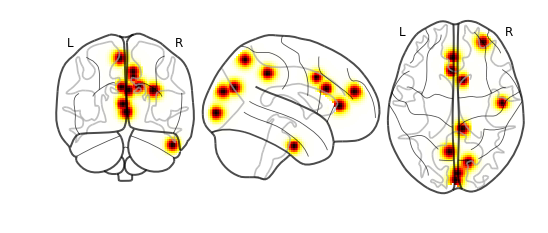

PCA = 2


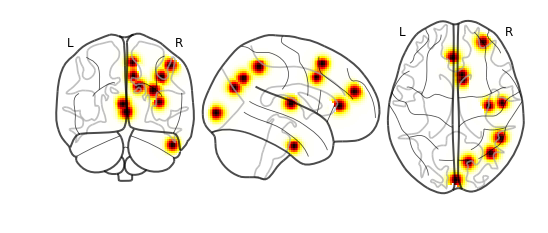

PCA = 3


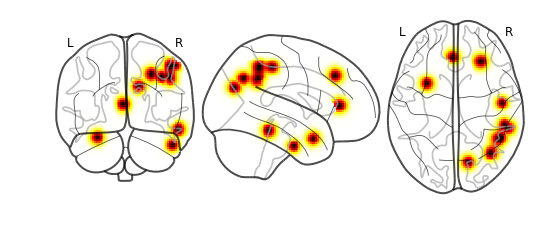

PCA = 4


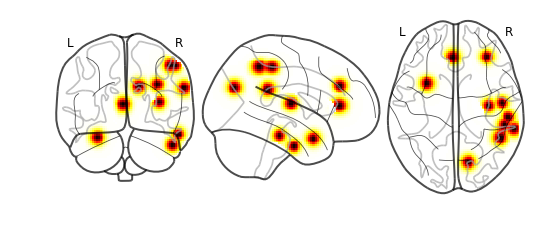

PCA = 5


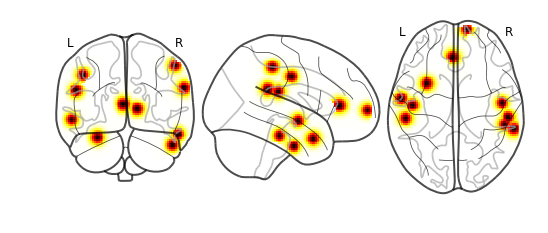

PCA = 6


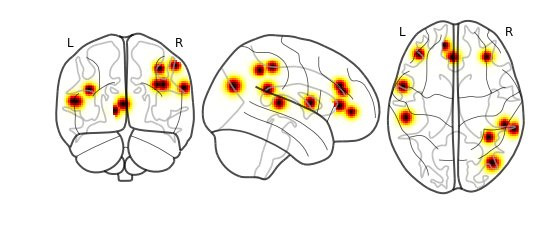

PCA = 7


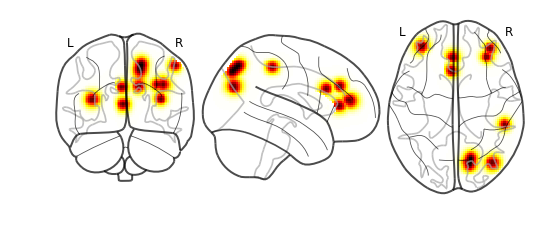

PCA = 8


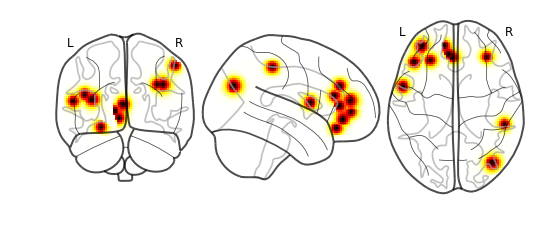

PCA = 9


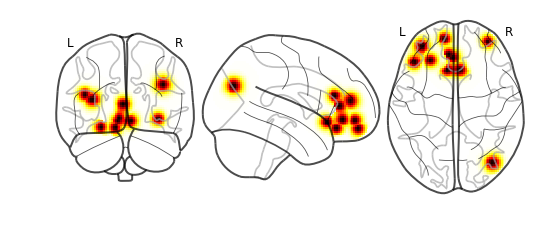

PCA = 10


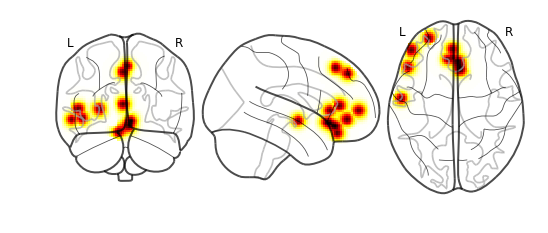

In [109]:
for i in np.arange(10):
    net_inds = largest_indices(np.atleast_2d(approximation_combined[i]).mean(axis=0), 10)
    temp_locs = centers[net_inds]
    temp_widths = widths[net_inds]
    w = rbf(temp_locs, temp_widths, template.get_locs().values)
    b = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=template.get_locs(), minimum_voxel_size=2)
    nii = se.Nifti(b)
    print('PCA = ' + str(i + 1))
    nii.plot_glass_brain()

In [111]:
w.shape

(10, 171094)

In [82]:
net_inds = largest_indices(np.atleast_2d(approximation_combined[0]).mean(axis=0), 10)

In [63]:
template = se.helpers._gray(res=2)
w = rbf(centers, widths, template.get_locs().values)

In [84]:
temp_locs = centers[net_inds]
temp_widths = widths[net_inds]
w = rbf(temp_locs, temp_widths, template.get_locs().values)
b = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=template.get_locs(), minimum_voxel_size=2)
nii = se.Nifti(b)
nii.plot_glass_brain()

In [135]:
newbrain = se.Brain(data=widths, locs=centers)

In [137]:
nii_b = se.Nifti(newbrain)

In [130]:
b = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=template.get_locs(), minimum_voxel_size=2)

In [131]:
nii = se.Nifti(b)

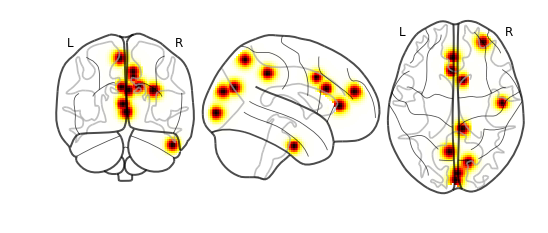

In [85]:
nii.plot_glass_brain()

In [15]:
# intact = hyp.describe(list(data[conds == 'intact']), reduce='PCA', show=False)
# paragraph = hyp.describe(list(data[conds == 'paragraph']), reduce='PCA', show=False)
# word = hyp.describe(list(data[conds == 'word']), reduce='PCA', show=False)
# rest = hyp.describe(list(data[conds == 'rest']), reduce='PCA', show=False)

/usr/local/lib/python3.6/site-packages/hypertools/tools/describe.py:61: UserWarning: When input data is large, this computation can take a long time.
  warnings.warn('When input data is large, this computation can take a long time.')


KeyboardInterrupt: 

In [ ]:
pca_pd = pd.DataFrame({'intact':intact['average'],'paragraph':paragraph['average'],'word':word['average'],'rest':rest['average']})


In [ ]:
pca_pd.head()

In [ ]:
pieman_conds

In [40]:

# max_dims = len(intact['average'])
# colors=['r', 'y', 'g', 'b']
# fig, ax = plt.subplots()
# for i, c in enumerate(pieman_conds):
#     print(i)
#     sns.tsplot(data=pca_pd[c], time=[n for n in range(2, max_dims+2)], color=colors[i], err_style="unit_traces", ax=ax)
# ax.set_title('Correlation with raw data by number of components')
# ax.set_ylabel('Correlation')
# ax.set_xlabel('Number of components')
# ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
# plt.axhline(y=.9, c='k',linestyle='dashed',zorder=-1)
# plt.show()

NameError: name 'intact' is not defined

## pieman pca decoding

In [149]:
resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100'

In [150]:
conds =glob.glob(os.path.join(resultsdir, '*.csv'))

In [151]:
conds

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/intact.csv',
 '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/paragraph.csv',
 '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/rest.csv',
 '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/word.csv']

In [152]:
full_data = pd.DataFrame()
for c in conds:
    data = pd.read_csv(c)
    data['condition'] = os.path.basename(os.path.splitext(c)[0])

    if full_data.empty:
        full_data = data
    else:
        full_data = full_data.append(data)

In [153]:
full_data

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,condition
0,0,0.763222,0.006667,0.458911,1,0,0,intact
1,0,0.705522,0.010000,0.333711,2,0,0,intact
2,0,0.773344,0.020000,0.321156,3,0,0,intact
3,0,0.765333,0.006667,0.315078,4,0,0,intact
4,0,0.852389,0.066667,0.230633,5,0,0,intact
5,0,0.877244,0.063333,0.203222,6,0,0,intact
6,0,0.895533,0.066667,0.192889,7,0,0,intact
7,0,0.933111,0.090000,0.149878,8,0,0,intact
8,0,0.937300,0.106667,0.133511,9,0,0,intact
9,0,0.937922,0.116667,0.142544,10,0,0,intact


In [154]:
full_data[full_data['condition']=='intact'].head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,condition
0,0,0.763222,0.006667,0.458911,1,0,0,intact
1,0,0.705522,0.010000,0.333711,2,0,0,intact
2,0,0.773344,0.020000,0.321156,3,0,0,intact
3,0,0.765333,0.006667,0.315078,4,0,0,intact
4,0,0.852389,0.066667,0.230633,5,0,0,intact


In [155]:
outfile = os.path.join(figdir, 'Accuracy_by_components.pdf')

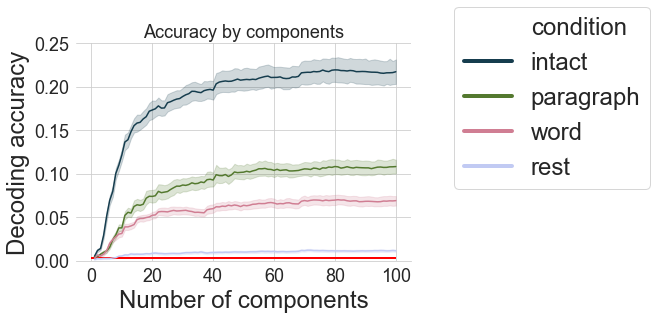

In [157]:
fig, ax = plt.subplots()
sns.lineplot(x="dims", y="accuracy",
             hue="condition",
             data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
sns.despine(ax=ax, left=True)
ax.set_title('Accuracy by components')
ax.set_ylabel('Decoding accuracy',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)
ax.set_ylim(0, .25)
ax.hlines(y=1/300, xmin=0, xmax=100, linewidth=2, color='r')
#ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
for line in l.get_lines():
    line.set_linewidth(4.0)
fig.savefig(outfile, bbox_inches='tight')

In [50]:
resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_chunked/PCA/ndims_100'

In [51]:
conds =glob.glob(os.path.join(resultsdir, '*.csv'))

In [52]:
full_data = pd.DataFrame()
for c in conds:
    data = pd.read_csv(c)
    data['condition'] = os.path.basename(os.path.splitext(c)[0])

    if full_data.empty:
        full_data = data
    else:
        full_data = full_data.append(data)

In [53]:
full_data[full_data['condition']=='intact'].head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,third,condition
0,0,0.835978,0.010000,0.486389,1,0,1,0,intact
1,0,0.755456,0.010000,0.345556,2,0,1,0,intact
2,0,0.777344,0.016667,0.288767,3,0,1,0,intact
3,0,0.853167,0.093333,0.230400,4,0,1,0,intact
4,0,0.896922,0.100000,0.229467,5,0,1,0,intact


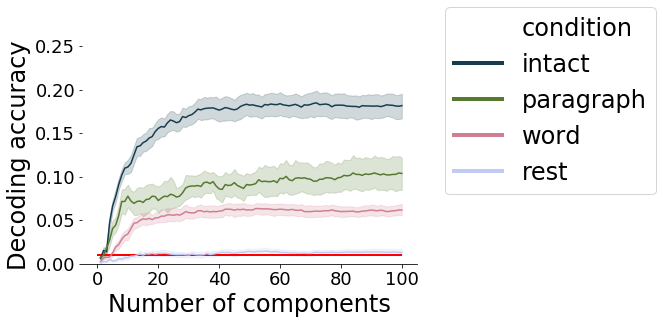

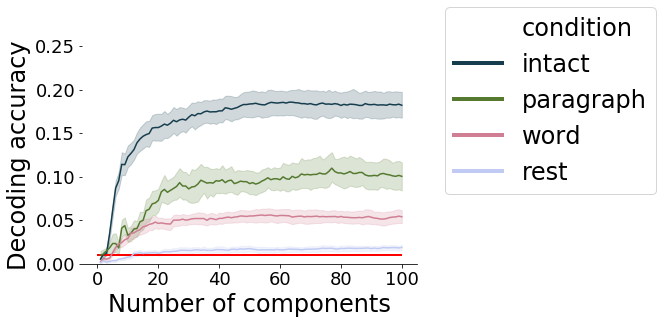

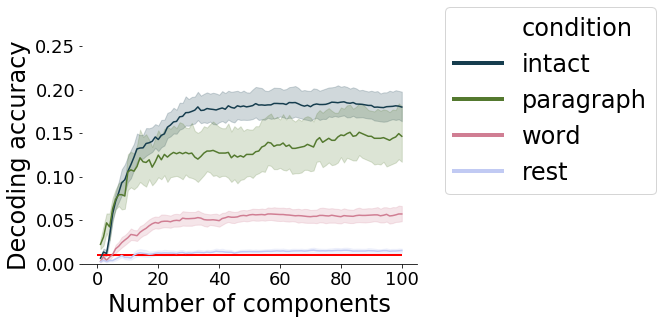

In [54]:
for i in range(3):
    outfile = os.path.join(figdir, 'Accuracy_by_components_third_' + str(i) + '.pdf')
    fig, ax = plt.subplots()
    sns.lineplot(x="dims", y="accuracy",
                 hue="condition",
                 data=full_data[full_data['third']==i], ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
    sns.despine(ax=ax, left=True)
    #ax.set_title('Accuracy by components for third: ' + str(i + 1))
    ax.set_ylabel('Decoding accuracy',fontsize=24)
    ax.set_xlabel('Number of components',fontsize=24)
    ax.set_ylim(0, .25)
    ax.hlines(y=1/100, xmin=0, xmax=100, linewidth=2, color='r')
    l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
    for line in l.get_lines():
        line.set_linewidth(4.0)
    fig.savefig(outfile, bbox_inches='tight')